# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://127.0.0.1:27017/")

db = client['Twitter']
All_Tweets_collection = db['Twitter_mdp_extend_datetime']


In [2]:
import pandas as pd
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)



# sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
#                                      allowDiskUse=True
#                                    )))


time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2020,4,1,0,0,0),
                                    '$lt': datetime.datetime(2020,5,1,0,0,0)},
            'retweeted_status': None
            })
        ))



In [114]:
import json
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 0)
    
    
filepath = '/home/lisa/Darmstadt/Master Arbeit/05_Data/Scrapy/Twitter_user/Twitter_user/spiders/'
parteien = ['Union', 'SPD', 'Gruene', 'Linke', 'FDP', 'AFD']
parteien_list= {}

user_df = pd.DataFrame(list(time_sample_df.user)) 

for partei in parteien:
    with open(filepath + partei + '_twitter_clean.json', newline='\n') as json_file:
        Screennames = json.load(json_file)
        parteien_list[str(partei)] = Screennames
        

#for name in set(user_df.screen_name):  #set statt list, wir brauchen jeden User nur einmal
for user in set(time_sample_df.user):
    for partei in parteien_list:
        name = user.name
        if name in parteien_list[partei]:
            print("Mapping party '%s' for user '%s'" % (partei,name))
            #print(partei)
            #time_sample_df.at[user_df.screen_name == name, 'Partei'] = partei
            #print(time_sample_df['Partei'])
            print(time_sample_df.loc["user" == user])
            time_sample_df.loc["user.screen_name" == name,'Partei'] = partei

#         else:
#             emo_df.at[word, emo] = 0

time_sample_df

TypeError: unhashable type: 'dict'

#### Create new Column date_time - erledigt in Datenbank

created_at is saved in Mongodb as string and needs to be converted to a datetime format

https://www.programiz.com/python-programming/datetime/strptime

In [15]:
# from datetime import datetime

# created_at_datetime = []
# for date in sample_df.created_at:
#     date_string = date
#     date_object = datetime.strptime(date_string, "%a %b %d %H:%M:%S +0000 %Y")
#     created_at_datetime.append(date_object)
    
# sample_df["date_time"] = created_at_datetime
# #sample_df.head()

#### Remove Retweets - erledig bei laden in Notebook
Zu erkennen sind Retweets am "RT" vor dem Text bzw. an der Spalte "retweeted_status"

In [16]:
# sample_text = sample_df[["created_at_datetime", "full_text", 'retweeted_status']]
# text_df = pd.DataFrame(sample_text)
# text_nRT = sample_text[pd.isnull(sample_text['retweeted_status'])]

### Text Cleaning

In [17]:
# Load the regular expression library
pd.set_option('display.max_colwidth', 0)
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


sample_df=time_sample_df
# Remove punctuation
sample_df['full_text_processed'] = sample_df['full_text'].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))
# Remove Links
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: re.sub('http.*', '', x))

sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: re.sub('amp', '', x))
# Convert the titles to lowercase
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
sample_df['full_text_processed'].head(200)

0      hat eigentlich schon irgendeine altpartei oder altfraktion einen plan/ eine strategie den stillstand zu beenden und  wieder hochzufahren die afd hat auch hier mal wieder die nase vorn                  
1      kein mensch braucht umfaller/ fdp weder in der politik noch in den medien                                                                                                                                
2      wer hat noch nicht wer will nochmal brandnerauftelegram afd berlin bundestag brandner                                                                                                                    
3      fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt                                                                                                                               
4      fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt                                                                                   

#### Durchsuche nach Tweets und sortiere aus

In [18]:
# Print words that match certain words:
#sample_df['full_text_processed'][sample_df['full_text_processed'].str.match(r'.*fröhlicher gruss.*')==True]

# Remove Tweets that match certain words:
sample_df = sample_df[~sample_df.full_text_processed.str.contains("fröhlicher gruss")]


#### Stopwords

In [19]:
#from stop_words import get_stop_words
#stop_words = get_stop_words('de')

import stopwordsiso as stopwords
stop_words = list(stopwords.stopwords(["de"])) 

mehr_sw = ['der', 'die', 'das', 'ist' 'es', 'gibt', 'und', 'für', 'auf', 'aus', 'mit', 'dem', 'tb']
for word in mehr_sw:
    stop_words.append(word)
    


#### Binning 
Diskretisierung von date_time

In [20]:
# Sortieren nach Datum/Zeit
sample_df = sample_df.sort_values(by = ['created_at_datetime'])

#### Verschiedene Binning Ansätze - aus verschiedenen Gründen nicht verwendet
* Bins mit vorgegebenen Breiten (Y, M, ...) -> Labels können nicht mitgenommen werden
* Binning mit value_count -> Direkte Ausgabe der Anzahl pro Bin
* Binning mit groupby -> Ausgabe der Indices

In [21]:
# cut_bins = pd.interval_range(start=pd.Timestamp('2020-02-01'), periods=9, freq='M')
# cut_labels = [i for i in range(2009,2021)]
# pd.cut(text_nRT['created_at_datetime'], bins=cut_bins, labels=cut_labels)


# text_nRT['created_at_datetime'].value_counts(bins=9, sort=False)

# bins = text_nRT.groupby(pd.cut(text_nRT['created_at_datetime'], bins=9, labels=list(range(1,10))))
# for b in bins.indices:
#     print(b)

#### Unterteilung in Bins und erstellen eines Dictionarys für Zeiträume

In [22]:
sample_df['bins'] = pd.cut(sample_df['created_at_datetime'], bins=9, labels=list(range(1,10)))

labels=list(range(1,10))
weeks = {}
    
for i in labels:
    weeks['week_'+str(i)] = sample_df[sample_df['bins'] == i]    
# Unsaubere Variante - jeweils Variable erstellen:
# globals()['week_'+str(i)] = text_nRT[text_nRT['bins'] == i]

bin_sum_per_week = {}

for label in range(1,10): 
    df = sample_df[sample_df['bins'] == label]
    head = list(df.created_at_datetime.head(1))[0]
    tail = list(df.created_at_datetime.tail(1))[0]
    #print(head.to_datetime)
    #print(type(head))
    bin_sum_per_week[label] = {}
    bin_sum_per_week[label]['Von'] = head
    bin_sum_per_week[label]['Bis'] = tail
bin_sum_per_week


{1: {'Von': Timestamp('2020-04-01 00:24:41'),
  'Bis': Timestamp('2020-04-02 12:20:30')},
 2: {'Von': Timestamp('2020-04-02 12:21:52'),
  'Bis': Timestamp('2020-04-03 23:34:30')},
 3: {'Von': Timestamp('2020-04-04 00:30:57'),
  'Bis': Timestamp('2020-04-05 12:13:38')},
 4: {'Von': Timestamp('2020-04-05 12:24:23'),
  'Bis': Timestamp('2020-04-06 23:18:00')},
 5: {'Von': Timestamp('2020-04-07 04:34:36'),
  'Bis': Timestamp('2020-04-08 12:06:03')},
 6: {'Von': Timestamp('2020-04-08 12:07:50'),
  'Bis': Timestamp('2020-04-09 23:32:09')},
 7: {'Von': Timestamp('2020-04-10 00:42:27'),
  'Bis': Timestamp('2020-04-11 11:58:33')},
 8: {'Von': Timestamp('2020-04-11 12:02:37'),
  'Bis': Timestamp('2020-04-12 23:00:00')},
 9: {'Von': Timestamp('2020-04-13 05:04:23'),
  'Bis': Timestamp('2020-04-14 11:54:05')}}

#### Weitere Tests

In [23]:
for i in labels:
    weeks['week_'+str(i)] = sample_df[sample_df['bins'] == i] 

### Wordcloud Basic

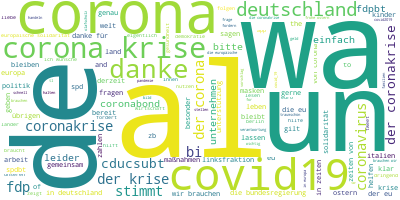

In [24]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(sample_df['full_text_processed'])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#fig, axs = plt.subplots(1,2)

#df['korisnika'].plot(ax=axs[0])
#df['osiguranika'].plot(ax=axs[1])

### Wordcloud Gegenüberstellung

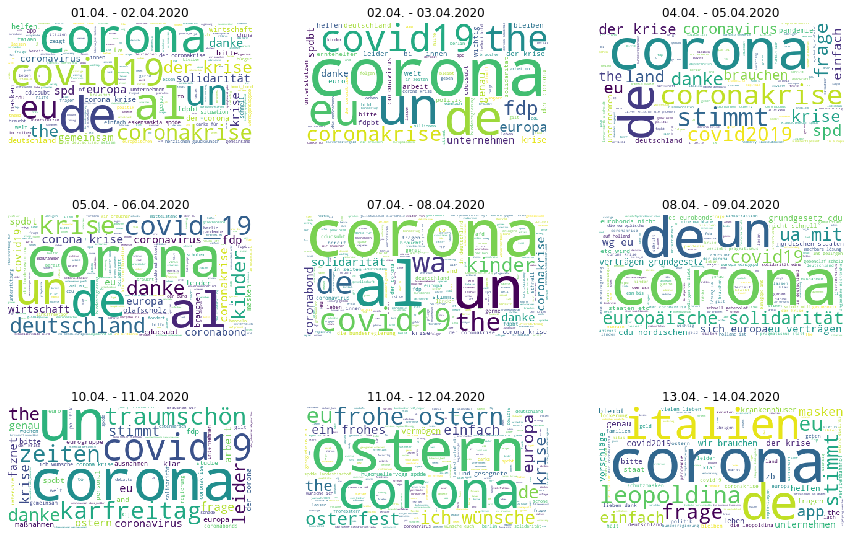

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud


for i in labels:
    weeks['week_'+str(i)] = sample_df[sample_df['bins'] == i]  

def FktWordCloud(long_string):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words)
    wordcloud.generate(long_string)
    wordcloud.to_image()
    return wordcloud

fig = plt.figure(figsize = (15, 10))
for i, n in zip(weeks, range(1,10)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    ax = fig.add_subplot(3,3,n, title = title)
    sample_df=weeks[i]
    long_string = ','.join(sample_df['full_text_processed'])
    wordcloud = FktWordCloud(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')

### Barplot Basic

In [ ]:
# # Load the library with the CountVectorizer method
# from sklearn.feature_extraction.text import CountVectorizer
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_style('whitegrid')
# %matplotlib inline

# # Helper function
# def plot_10_most_common_words(count_data, count_vectorizer):
#     import matplotlib.pyplot as plt
#     words = count_vectorizer.get_feature_names()
#     total_counts = np.zeros(len(words))
#     for t in count_data:
#         total_counts+=t.toarray()[0]
    
#     count_dict = (zip(words, total_counts))
#     count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
#     words = [w[0] for w in count_dict]
#     counts = [w[1] for w in count_dict]
#     x_pos = np.arange(len(words)) 
    
#     plt.figure(2, figsize=(15, 15/1.6180))
#     plt.subplot(title='10 most common words')
#     sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
#     sns.barplot(x_pos, counts, palette='husl')
#     plt.xticks(x_pos, words, rotation=90) 
#     plt.xlabel('words')
#     plt.ylabel('counts')
#     plt.show()
    
# # Initialise the count vectorizer with the german stop words
# count_vectorizer = CountVectorizer(stop_words=stop_words)

# # Fit and transform the processed titles
# count_data = count_vectorizer.fit_transform(weeks['week_9']['full_text_processed'])
# # Visualise the 10 most common words
# plot_10_most_common_words(count_data, count_vectorizer)


### Barplot Gegenüberstellung

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wahr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


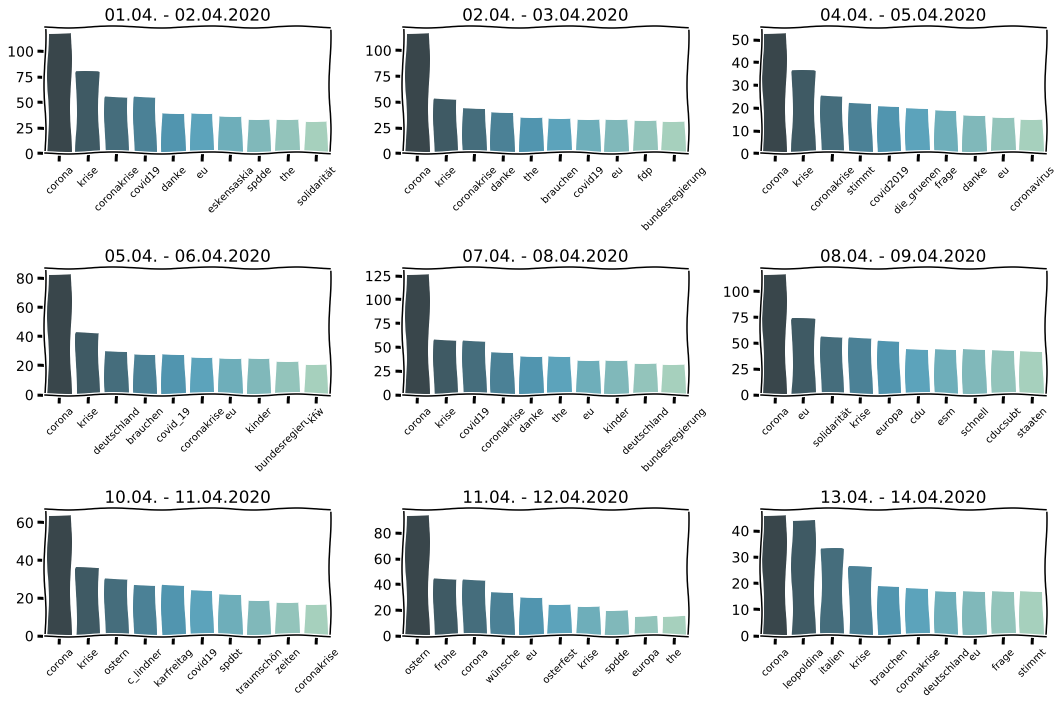

In [27]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer, title):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0] # total_counts = total_counts + t.toarray
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    
    with plt.xkcd():
        ax = fig.add_subplot(3,3,n, title =  title)
        fig.tight_layout()
        ax = sns.barplot(x_pos, counts, palette="GnBu_d")
        ax.set_xticklabels(words, rotation = 45, fontsize=10)
        return ax

    
# Initialise the count vectorizer with the german stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)


fig = plt.figure(figsize = (15, 10))
for i, n in zip(weeks, range(1,10)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    
    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform(weeks[i]['full_text_processed'])
    plot_10_most_common_words(count_data, count_vectorizer, title)
    
plt.show()


In [28]:
import warnings

warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
stimmt dielinke joergschindler netnrd jan_vanaken masken bundeswehr italien frage kahrs

Topic #1:
corona italien einfach krise unternehmen helfen politik sehe reden cducsubt

Topic #2:
leopoldina katjakipping nowabofm corona italien ralf_stegner lieblingxhain die_gennburg kuehnikev andreass2904

Topic #3:
leopoldina eu covid19 sixtus schutzmasken lage bitte lach fordern deutschland

Topic #4:
corona krise leopoldina pandemie covid2019 lieben italien bleibt brauchen eskensaskia


In [30]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import os
import pyLDAvis
LDAvis_data_filepath = os.path.join('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/ldavis_prepared_'+ str(number_topics) +'.html')

FileNotFoundError: [Errno 2] No such file or directory: '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/ldavis_prepared_5'

In [ ]:
pyLDAvis.display(LDAvis_prepared)

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
import nltk
#nltk.download('punkt')
from nltk import word_tokenize 
from nltk.util import ngrams
import matplotlib.pyplot as plt
import seaborn as sns

bigram=[]
   

def make_bigrams_network (df):
    for tweet in df:
        word_data = tweet
        tokens = nltk.word_tokenize(word_data)                            # -> Einzelne Wörter (Tokens)
        tweets_nsw = [word for word in tokens if not word in stop_words]  # -> Ohne StopWords
        terms_bigram = list(nltk.bigrams(tweets_nsw))                     # -> Zweierpärchen (Bigrams) 
        bigram.append(terms_bigram)
    
    terms_bigram = bigram
    #return terms_bigram
    # Flatten list of bigrams in clean tweets
    bigrams = list(itertools.chain(*terms_bigram))
    # Create counter of words in clean bigrams
    bigram_counts = collections.Counter(bigrams)
    bigram_counts.most_common(20)
    bigram_df = pd.DataFrame(bigram_counts.most_common(20), columns=['bigram', 'count'])

    # Create dictionary of bigrams and their counts
    d = bigram_df.set_index('bigram').T.to_dict('records')
    
    # Create network plot 
    G = nx.Graph()
    
    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))
        
    ax = fig.add_subplot(5,2,n, title =  title)
    fig.tight_layout()
    pos = nx.spring_layout(G, k=1)
    nx.draw_networkx(G, pos,
                 font_size=16, width=3, edge_color='grey', node_color='darkblue', with_labels = False, ax=ax)
    
    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y, s=key, bbox=dict(alpha=0.25), horizontalalignment='center', fontsize=10)
    
        
fig = plt.figure(figsize = (15, 25))

for i, n in zip(weeks, range(1,10)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    
    make_bigrams_network(weeks[i]['full_text_processed'])

plt.show()


/usr/local/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/usr/local/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/usr/local/anaconda3/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/lisa/nltk_data'
    - '/usr/local/anaconda3/nltk_data'
    - '/usr/local/anaconda3/share/nltk_data'
    - '/usr/local/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


<Figure size 1080x1800 with 0 Axes>

# Sentiment Analyse - Wörterbuch
## Simple TextBlob Analysis

In [ ]:
from textblob_de import TextBlobDE as TextBlob

blob = TextBlob(sample_df['full_text_processed'][8]) 

# print(blob.sentences)
# print(blob.tokens)
# print(blob.tags)
# print(blob.noun_phrases)
# print(blob.sentiment)

In [ ]:
# https://medium.com/@himanshu_23732/sentiment-analysis-with-textblob-6bc2eb9ec4ab
def sentiment(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None
    
sample_df['Polarity']     = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[0])
sample_df['Subjectivity'] = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[1])

In [ ]:
# compute sentiment scores (polarity) and labels
sentiment_scores = sample_df['Polarity']
sentiment_category = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores]


# sentiment statistics per news category
df = pd.DataFrame([list(sample_df['bins']), list(sentiment_scores), list(sentiment_category)]).T
df.columns = ['category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['category']).describe()

In [ ]:
labels = []
for i, n in zip(weeks, range(1,10)):
    label = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    labels.append(label)

ax = sns.catplot(x="category", hue="sentiment_category", height=13,
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})
ax.set_xticklabels(labels, rotation = 45, fontsize=12)

#print(labels)

## Basic Emotions

In [ ]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm


import csv
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('de_core_news_sm')

pd.set_option('display.max_colwidth', 0)
    
######### Erstelle Emotions-Matrix

filepath = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Lexicon_based/german-emotion-dictionary/fundamental/'
emo_df = []
words = []
emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']
emotion_list= {}
stemmer = SnowballStemmer("german")

for emo in emotion:
    with open(filepath + emo + '.txt', newline='\n') as f:
        reader = csv.reader(f)
        data = [item for sublist in reader for item in sublist] 
        emotion_list[str(emo)] = data
        words.extend(data)
        
words = list(set(words)) # remove Duplicates which come from overlapping EmotionLists
emo_df  = pd.DataFrame(index=words, columns=emotion)

words = []
for word in emo_df.index:
    for emo in emo_df.columns:
        if word in emotion_list[emo]:
            emo_df.at[word, emo] = 1
        else:
            emo_df.at[word, emo] = 0
    words.append(stemmer.stem(word.lower()))
 
emo_df.index= words
emo_df = emo_df.sort_index(ascending=True)
emo_df = pd.DataFrame(emo_df)
emo_df = emo_df.loc[~emo_df.index.duplicated(keep='first')]

emo_df.head()


In [ ]:
# print_debug = False
# def debug(string):
#     if print_debug == True:
#         print(string)

# for word in emo_df.index:
#      debug("'%s'" % (word))
#      debug(type(word))
#      #for emo in emotion_list:
#      for emo in emo_df.columns:
#          #print(emo)
#          #print(type(emo))
#          if word in emotion_list[emo]:
#              debug("Word '%s' is of emotion: '%s'" % (word, emo))
#              #print(emo_df[emo][word])
#              #print(emo_df.columns)
#              #print(emo_df.ix[1])
#              emo_df.at[word, emo] = 1
#              debug(emo_df.loc[word])
#              debug("\n")

#          #else:
#          #    emo_df.at[str(emo)][word] = 0

# emo_df[1:12]

In [ ]:
#from fuzzywuzzy import fuzz
new_df = sample_df['full_text_processed'][0:100]
df_emo = pd.DataFrame(0, index=new_df.index, columns=emotion)

for i in new_df.index:
    document = word_tokenize(new_df.loc[i])
    for word in document:
        word = stemmer.stem(word.lower())             # Stemming des einzelnen Wortes aus Tweet um es...
        emo_score = emo_df[emo_df.index == word]      # ... mit den Lexikon Worten zu vergleichen -> emo_score 

#         for w in emo_df.index:
#             fuz = fuzz.ratio(str(w), word)
#             if fuz > 98:
#                 emo_score = emo_df[emo_df.index == w].drop_duplicates(keep = 'first')    

        if not emo_score.empty:                       # der emo score eines Worts z.B. [0 0 1 1 0 0 0] 
            for emot in emotion:                      # wird zum Score des Tweets dazugezählt z.B.: [2 0 4 1 0 0 0]
                df_emo.at[i, emot] += emo_score[emot] # am Ende exisitiert zu einem Tweet 
                

new_df = pd.concat([new_df, df_emo], axis=1)

new_df.head(20)

In [ ]:
new_df.head(100)

In [ ]:
# emo_df[emo_df.index == word].sum(axis=1)

# #emo_df['sum'] = emo_df[emo_df.index].count()
# #emo_df[emo_df.index == word].drop_duplicates(subset = emo_df[emo_df.index == word].index, keep = 'first') 
# emo_df[emo_df.index == word].index

#stemmer.stem('rüstung')
emo_df[emo_df.index == 'rust']

In [ ]:
new_df.head(50)

In [ ]:
sample_df['full_text_processed'][1:9]

In [ ]:
from fuzzywuzzy import fuzz
# fuz = fuzz.ratio('trolle', 'troll')
# print(fuz)

#emo_df[emo_df.index == 'Trolle']
for word in emo_df.index:
    fuz = fuzz.ratio(str(word), 'trolle')
    if fuz > 90:
        print(word)
        print(fuz)
    

# for word in emo_df.index:
#     print(word.lower())

In [ ]:
from nltk import tokenize
from nltk import word_tokenize

new_df['word_count'] = new_df['full_text_processed'].apply(tokenize.word_tokenize).apply(len)
new_df

In [ ]:
for emo in emotion:
    new_df[emo] = new_df[emo] / new_df['word_count']
new_df

In [ ]:
for emo in emotion:
    print(emotion)

In [ ]:
type(sample_df['full_text_processed'])